In [1]:
import pandas as pd
import numpy as np
from math import sqrt, log2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, ndcg_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
import joblib
import json
from fancyimpute import KNN
from IPython.display import display_html
import matplotlib.pyplot as plt


def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline"'), raw=True)

In [2]:
df_train = pd.read_csv('train_users_2.csv')
df_test = pd.read_csv('test_users.csv')

# Data Preprocessing

In [39]:
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [40]:
df_test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [9]:
print('Target Classes: ' + str(np.unique(df_train['country_destination'].values)))
print('Train Set: ' + str(df_train.shape))
print('Test Set: ' + str(df_test.shape))

Target Classes: ['AU' 'CA' 'DE' 'ES' 'FR' 'GB' 'IT' 'NDF' 'NL' 'PT' 'US' 'other']
Train Set: (213451, 16)
Test Set: (62096, 15)


In [10]:
# Check if id coloumn is unique
print(df_train['id'].is_unique, df_test['id'].is_unique)

True True


In [13]:
print('Train Set\n----------------------')
print(df_train.info())
print()
print('\nTrain Set Null Values:\n----------------------')
for i in df_train.columns:
    sum = df_train[i].isnull().sum()
    if sum != 0:
        print(i + ': {}'.format(sum))

print('\n---------------------------------------------------------------------\n')

print('Test Set\n----------------------')
print(df_test.info())
print()
print('\nTest Null Values:\n----------------------')
for i in df_test.columns:
    sum = df_test[i].isnull().sum()
    if sum != 0:
        print(i + ': {}'.format(sum))

Train Set
----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        2

In [38]:
df1 = pd.DataFrame(data=df_train['age'].describe())
df2 = pd.DataFrame(data=df_test['age'].describe())
df1.rename(columns={'age': 'Train Age'}, inplace=True)
df2.rename(columns={'age': 'Test Age'}, inplace=True)
display_side_by_side(df1, df2)
df1 = pd.DataFrame(data=df_train['gender'].value_counts())
df2 = pd.DataFrame(data=df_test['gender'].value_counts())
df1.rename(columns={'gender': 'Train Gender'}, inplace=True)
df2.rename(columns={'gender': 'Test Gender'}, inplace=True)
display_side_by_side(df1, df2)


,Train Age
count,125461.000000
mean,49.668335
std,155.666612
min,1.000000
25%,28.000000
50%,34.000000
75%,43.000000
max,2014.000000
,Test Age
count,33220.000000


,Train Gender
-unknown-,95688
FEMALE,63041
MALE,54440
OTHER,282
,Test Gender
-unknown-,33792
FEMALE,14483
MALE,13769
OTHER,52


In [3]:
# -unknown- frequency in gender coloumn is nearly as half as much of the total number of samples.
# Removing or replacing this value with mean/media or imputing using knn will definitely generate noise. Therefore, it's best to leave it as is.
# Handling missing values for test sets is usually problematic especially for features that are both imprtant and have large numbers of missing values.
# I will concatenate train and test sets to fill missing values using knn and then seperate them back.
# This approach will ensure reasonable accuracy.

# No need for id coloumn
df_train.drop(['id'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)

# date_first_booking is completely empty in the test set, therefore we will remove this coloumn.
df_train.drop(['date_first_booking'], axis=1, inplace=True)
df_test.drop(['date_first_booking'], axis=1, inplace=True)

# There is a minimum age 1 and maximum 2014. Obviously there are outliers in the age coloumn. Taking Airbnb's terms of service into account (users must be 18 years or older), we will assume an age range between 18-117 (the age of the oldest living person as of 02/AUG/2020)
df_train['age'] = df_train['age'].apply(lambda x: np.nan if ((x < 18) or (x > 117)) else x)
df_test['age'] = df_test['age'].apply(lambda x: np.nan if ((x < 18) or (x > 117)) else x)

#df_train['age_bucket'] = pd.cut(df_train['age'], [18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 120], right=False)
#df_test['age_bucket'] = pd.cut(df_test['age'], [18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 120], right=False)

#df_train['gender'].replace('-unknown-', np.nan, inplace = True)
#df_test['gender'].replace('-unknown-', np.nan, inplace = True)

# Extracting different time features from 'date_account_created' and 'timestamp_first_active'
seasons = {1: 'winter', 2:'winter', 12:'winter', 3:'spring', 4:'spring', 5:'spring', 6:'summer', 7:'summer', 8:'summer', 9:'autumn', 10:'autumn', 11:'autumn'}

# Train Set
df_train['date_account_created'] = pd.to_datetime(df_train['date_account_created'])
df_train['year_ac'] = pd.DatetimeIndex(df_train['date_account_created']).year
df_train['month_ac'] = pd.DatetimeIndex(df_train['date_account_created']).month
df_train['day_ac'] = pd.DatetimeIndex(df_train['date_account_created']).day
df_train['weekday_ac'] = pd.DatetimeIndex(df_train['date_account_created']).weekday
df_train['season_ac'] = df_train['month_ac'].apply(lambda x: seasons[x])

df_train['time_first_active'] = pd.to_datetime((df_train['timestamp_first_active']), format='%Y%m%d%H%M%S')
df_train['year_fa'] = pd.DatetimeIndex(df_train['time_first_active']).year
df_train['month_fa'] = pd.DatetimeIndex(df_train['time_first_active']).month
df_train['day_fa'] = pd.DatetimeIndex(df_train['time_first_active']).day
df_train['weekday_fa'] = pd.DatetimeIndex(df_train['time_first_active']).weekday
df_train['season_fa'] = df_train['month_fa'].apply(lambda x: seasons[x])

df_train.drop(['date_account_created'], axis=1, inplace=True)
df_train.drop(['timestamp_first_active'], axis=1, inplace=True)
df_train.drop(['time_first_active'], axis=1, inplace=True)

# Test Set
df_test['date_account_created'] = pd.to_datetime(df_test['date_account_created'])
df_test['year_ac'] = pd.DatetimeIndex(df_test['date_account_created']).year
df_test['month_ac'] = pd.DatetimeIndex(df_test['date_account_created']).month
df_test['day_ac'] = pd.DatetimeIndex(df_test['date_account_created']).day
df_test['weekday_ac'] = pd.DatetimeIndex(df_test['date_account_created']).weekday
df_test['season_ac'] = df_test['month_ac'].apply(lambda x: seasons[x])

df_test['time_first_active'] = pd.to_datetime((df_test['timestamp_first_active']), format='%Y%m%d%H%M%S')
df_test['year_fa'] = pd.DatetimeIndex(df_test['time_first_active']).year
df_test['month_fa'] = pd.DatetimeIndex(df_test['time_first_active']).month
df_test['day_fa'] = pd.DatetimeIndex(df_test['time_first_active']).day
df_test['weekday_fa'] = pd.DatetimeIndex(df_test['time_first_active']).weekday
df_test['season_fa'] = df_test['month_fa'].apply(lambda x: seasons[x])

df_test.drop(['date_account_created'], axis=1, inplace=True)
df_test.drop(['timestamp_first_active'], axis=1, inplace=True)
df_test.drop(['time_first_active'], axis=1, inplace=True)


In [42]:
df1 = pd.DataFrame(data=df_train['age'].describe())
df2 = pd.DataFrame(data=df_test['age'].describe())
df1.rename(columns={'age': 'Train Age'}, inplace=True)
df2.rename(columns={'age': 'Test Age'}, inplace=True)
display_side_by_side(df1, df2)

,Train Age
count,124522.000000
mean,37.443857
std,13.930721
min,18.000000
25%,28.000000
50%,34.000000
75%,43.000000
max,115.000000
,Test Age
count,33141.000000


# Simple Dimensionality Reduction

In [44]:
df1 = pd.DataFrame(data=df_train['signup_method'].value_counts())
df2 = pd.DataFrame(data=df_test['signup_method'].value_counts())
df1.rename(columns={'signup_method': 'Train signup_method'}, inplace=True)
df2.rename(columns={'signup_method': 'Test signup_method'}, inplace=True)
display_side_by_side(df1, df2)

df1 = pd.DataFrame(data=df_train['signup_flow'].value_counts())
df2 = pd.DataFrame(data=df_test['signup_flow'].value_counts())
df1.rename(columns={'signup_flow': 'Train signup_flow'}, inplace=True)
df2.rename(columns={'signup_flow': 'Test signup_flow'}, inplace=True)
display_side_by_side(df1, df2)

df1 = pd.DataFrame(data=df_train['language'].value_counts())
df2 = pd.DataFrame(data=df_test['language'].value_counts())
df1.rename(columns={'language': 'Train language'}, inplace=True)
df2.rename(columns={'language': 'Test language'}, inplace=True)
display_side_by_side(df1, df2)

df1 = pd.DataFrame(data=df_train['affiliate_provider'].value_counts())
df2 = pd.DataFrame(data=df_test['affiliate_provider'].value_counts())
df1.rename(columns={'affiliate_provider': 'Train affiliate_provider'}, inplace=True)
df2.rename(columns={'affiliate_provider': 'Test affiliate_provider'}, inplace=True)
display_side_by_side(df1, df2)

df1 = pd.DataFrame(data=df_train['first_device_type'].value_counts())
df2 = pd.DataFrame(data=df_test['first_device_type'].value_counts())
df1.rename(columns={'first_device_type': 'Train first_device_type'}, inplace=True)
df2.rename(columns={'first_device_type': 'Test first_device_type'}, inplace=True)
display_side_by_side(df1, df2)

df1 = pd.DataFrame(data=df_train['first_browser'].value_counts())
df2 = pd.DataFrame(data=df_test['first_browser'].value_counts())
df1.rename(columns={'first_browser': 'Train first_browser'}, inplace=True)
df2.rename(columns={'first_browser': 'Test first_browser'}, inplace=True)
display_side_by_side(df1, df2)

,Train signup_method
basic,152897
facebook,60008
google,546
,Test signup_method
basic,45325
facebook,14856
google,1892
weibo,23


,Train signup_flow
0,164739
25,14659
12,9329
3,8822
2,6881
24,4328
23,2835
1,1047
6,301
8,240


,Train language
en,206314
zh,1632
fr,1172
es,915
ko,747
de,732
it,514
ru,389
pt,240
ja,225


,Train affiliate_provider
direct,137426
google,51693
other,12549
craigslist,3471
bing,2328
facebook,2273
vast,829
padmapper,768
facebook-open-graph,545
yahoo,496


,Train first_device_type
Mac Desktop,89600
Windows Desktop,72716
iPhone,20759
iPad,14339
Other/Unknown,10667
Android Phone,2803
Android Tablet,1292
Desktop (Other),1199
SmartPhone (Other),76
,Test first_device_type


,Train first_browser
Chrome,63845
Safari,45169
Firefox,33655
-unknown-,27266
IE,21068
Mobile Safari,19274
Chrome Mobile,1270
Android Browser,851
AOL Explorer,245
Opera,188


In [4]:
df_temp = pd.concat([df_train,df_test], keys=[0,1])

# Frequency dictionaries
frq_suf = df_temp['signup_flow'].value_counts().to_dict()
frq_lang = df_temp['language'].value_counts().to_dict()
frq_ap = df_temp['affiliate_provider'].value_counts().to_dict()
frq_fdt = df_temp['first_device_type'].value_counts().to_dict()
frq_brws = df_temp['first_browser'].value_counts().to_dict()

threshold = 37 #group values below this threshold

df_temp['signup_flow'] = df_train['signup_flow'].apply(lambda x: 'other' if frq_suf[x] < threshold else x)
df_temp['language'] = df_train['language'].apply(lambda x: 'other' if frq_lang[x] < threshold else x)
df_temp['affiliate_provider'] = df_train['affiliate_provider'].apply(lambda x: 'other' if frq_ap[x] < threshold else x)
df_temp['first_device_type'].replace(['Mac Desktop', 'Windows Desktop', 'Desktop (Other)'], 'Desktop', inplace = True)
df_temp['first_device_type'].replace(['iPhone', 'Android Phone', 'SmartPhone (Other)'], 'Smartphone', inplace = True)
df_temp['first_device_type'].replace(['iPad', 'Android Tablet'], 'Tablet', inplace = True)
df_temp['first_browser'] = df_train['first_browser'].apply(lambda x: 'other' if frq_brws[x] < threshold else x)

# Previously I extracted seasons from month_ac and month_fa to use for prediction and data visualisation.
# I realise now that this may create problems when predicting due to the fact that month and season features are highly correlated.
# Will be kept above for visualisation purposes (later).
df_temp.drop(['season_ac', 'season_fa'], axis=1, inplace=True)

# Since we now have day of the week, I'll drop the day coloumns
#df_temp.drop(['day_ac', 'day_fa'], axis=1, inplace=True)

# Labelling values



In [5]:
# First, I will combine train and test sets into a temporary dataframe to fill missing values using knn.
# The temp dataframe will be seperated back into train and test sets after imputation.
# first_affiliate_tracked coloumn has null values that need to be imputed.
# country_destination will have new null values after combining datasets.
# Non-null values of first_affiliate_tracked and country_destination will be encoded seperately and inserted back into df_temp using numpy squeeze.

#df_temp = pd.concat([df_train,df_test], keys=[0,1])

categories = ['gender', 'signup_method', 'signup_flow', 'language',  'affiliate_channel', 'affiliate_provider', 'signup_app', 'first_device_type', 'first_browser']
le = LabelEncoder()
le_f = LabelEncoder()

first_affiliate_nonulls = np.array(df_temp['first_affiliate_tracked'].dropna())
first_affiliate_nonulls = first_affiliate_nonulls.reshape(-1,1)
first_affiliate_encoded = le_f.fit_transform(first_affiliate_nonulls)
df_temp['first_affiliate_tracked'].loc[df_temp['first_affiliate_tracked'].notnull()] = np.squeeze(first_affiliate_encoded)

country_dest_nonulls = np.array(df_temp['country_destination'].dropna())
country_dest_nonulls = country_dest_nonulls.reshape(-1,1)
country_dest_encoded = le.fit_transform(country_dest_nonulls)
df_temp['country_destination'].loc[df_temp['country_destination'].notnull()] = np.squeeze(country_dest_encoded)

for i in categories:
    df_temp[i] = le_f.fit_transform(df_temp[i])


# Missing Values Imputation

In [ ]:
# Imputation (This will take ~20 minutes)
# You can skip this step. I've already run it and exported the filled df to df_impute.csv (included in main directory)

def get_k(n, chunks=10):
    k = round(sqrt(n/chunks))
    if k % 2 == 0:
        return k-1
    else:
        return k
        
chunks = 10
k = get_k(n=df_temp.shape[0], chunks=chunks)
df_temp_2 = df_temp.copy()
df_temp_2.drop(['country_destination'], axis=1, inplace=True)
cols = list(df_temp_2.columns)
df_impute = pd.DataFrame()

for chunk in np.array_split(df_temp_2, chunks):
    chunk = np.round(KNN(k=k).fit_transform(chunk))
    df_chunk = pd.DataFrame(data=chunk, columns=cols)
    df_impute = pd.concat([df_impute, df_chunk], axis=0, ignore_index=True)

df_impute.to_csv('df_impute.csv')

In [6]:
# Run this cell if you skipped the previous one.
df_impute = pd.read_csv('df_impute.csv')

In [48]:
# This cell is just for making sure nothing is messed up before imputing into df_temp
# Check for null values

x = 0
for i in df_impute.columns:
    sum = df_impute[i].isnull().sum()
    if sum != 0:
        print(i + ' has: {}'.format(sum) + ' NaN')
        x += 1
if x == 0:
    print('No null values in df_impute.\n')

# First, insert imputed values from df_impute into a new temp df to ensure order
age_imputed = df_impute['age'].to_numpy()
fa_imputed = df_impute['first_affiliate_tracked'].to_numpy()

df_temp_4 = df_temp.copy()
df_temp_4['age'] = age_imputed
df_temp_4['first_affiliate_tracked'] = fa_imputed

print('Original shape\tFilled shape')
print(''+str(df_temp.shape)+'\t'+str(df_temp_4.shape))

print('\nOriginal\t\tFilled')
display_side_by_side(df_temp[['age', 'first_affiliate_tracked']].head(10), df_temp_4[['age', 'first_affiliate_tracked']].head(10))

#splitting df_temp
df_train_2, df_test_2 = df_temp.xs(0), df_temp.xs(1)
df_test_2.drop(['country_destination'], axis=1, inplace=True)

#splitting df_temp_4
df_train_3, df_test_3 = df_temp_4.xs(0), df_temp_4.xs(1)
df_test_3.drop(['country_destination'], axis=1, inplace=True)

print('\nOriginal train\t\tFilled train')
display_side_by_side(df_train_2[['age', 'first_affiliate_tracked']].head(10), df_train_3[['age', 'first_affiliate_tracked']].head(10))
print('\nOriginal test\t\tFilled test')
display_side_by_side(df_test_2[['age', 'first_affiliate_tracked']].head(10), df_test_3[['age', 'first_affiliate_tracked']].head(10))


No null values in df_impute.

Original shape	Filled shape
(275547, 20)	(275547, 20)

Original		Filled


age 
 first_affiliate_tracked 
 
 
 
 
 0 
 0 
 NaN 
 6 
 
 
 1 
 38.0 
 6 
 
 
 2 
 56.0 
 6 
 
 
 3 
 42.0 
 6 
 
 
 4 
 41.0 
 6 
 
 
 5 
 NaN 
 3 
 
 
 6 
 46.0 
 6 
 
 
 7 
 47.0 
 3 
 
 
 8 
 50.0 
 6 
 
 
 9 
 46.0 
 3 
 
 
 
 
 
 
 
 age 
 first_affiliate_tracked 
 
 
 
 
 0 
 0 
 38.0 
 6.0 
 
 
 1 
 38.0 
 6.0 
 
 
 2 
 56.0 
 6.0 
 
 
 3 
 42.0 
 6.0 
 
 
 4 
 41.0 
 6.0 
 
 
 5 
 39.0 
 3.0 
 
 
 6 
 46.0 
 6.0 
 
 
 7 
 47.0 
 3.0 
 
 
 8 
 50.0 
 6.0 
 
 
 9 
 46.0 
 3.0


Original train		Filled train


,age,first_affiliate_tracked
0,NaN,6
1,38.0,6
2,56.0,6
3,42.0,6
4,41.0,6
5,NaN,3
6,46.0,6
7,47.0,3
8,50.0,6
9,46.0,3



Original test		Filled test


,age,first_affiliate_tracked
0,35.0,6
1,NaN,6
2,NaN,0
3,NaN,0
4,NaN,6
5,28.0,3
6,48.0,6
7,NaN,6
8,NaN,6
9,NaN,3


In [7]:
# Now that we can split the data back safely, we can apply this on our data

age_imputed = df_impute['age'].to_numpy()
fa_imputed = df_impute['first_affiliate_tracked'].to_numpy()

df_temp['age'] = age_imputed
df_temp['first_affiliate_tracked'] = fa_imputed

df_target = df_temp.xs(0)['country_destination']
target = df_target.values

df_temp.drop(['country_destination'], axis=1, inplace=True)


# Encoding Values

In [8]:
categories = ['gender', 'signup_method', 'signup_flow', 'language',  'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
ct = ColumnTransformer([('encoder', OneHotEncoder(), categories)], remainder='passthrough')
matrix = ct.fit_transform(df_temp)
df = pd.DataFrame(matrix)
train = df[:len(df_train)]
test = df[len(df_train):]

train = train.values
test = test.values
df_target = df_target.astype(int)
target = df_target.values


# Modelling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.33, random_state=28, shuffle=True)

pd.DataFrame(X_train).to_csv('X_train.csv')
pd.DataFrame(X_test).to_csv('X_test.csv')
pd.DataFrame(y_train).to_csv('y_train.csv')
pd.DataFrame(y_test).to_csv('y_test.csv')

In [9]:
# This is a multi-class classification problem. The prediction output for each row is the top 5 country destinations
# with highest probability. Using sklearn accuracy metric won't give real accuracy.
# NDCG (Normalized Discounted Cumulative Gain) is the evaluation metric used for this competition.

def acc_ndcg(y_test, y_pred_proba):
    acc = []
    for i in range(len(y_pred_proba)):
        p = np.argsort(y_pred_proba[i])[-5:][::-1]
        t = y_test[i]
        try:
            index = int(np.where(p == t)[0][0]+1)
            dcg = 1/(log2(index + 1))
        except:
            dcg = 0.0
        acc.append(dcg)
    return np.mean(acc)


In [ ]:
# CatBoostClassifier max_depth grid search (This will take a very long time. Results are included in pdf)
# The code for the grid search is taken from this webpage: https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

model = catboost.CatBoostClassifier(loss_function='MultiClass', task_type='GPU')
max_depth = range(7, 16, 1)
param_grid = dict(max_depth=max_depth)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss")
grid_result = grid_search.fit(train, target)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

plt.errorbar(max_depth, means, yerr=stds)
plt.title("CatBoost max_depth vs Log Loss")
plt.xlabel('max_depth')
plt.ylabel('Log Loss')
plt.savefig('catboost_max_depth_2.png')


In [ ]:
# CatBoostClassifier learning_rate grid search (This will take a very long time. Results are included in pdf)
# The code for the grid search is taken from this webpage: https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

model = catboost.CatBoostClassifier(loss_function='MultiClass', task_type='GPU', max_depth=11)
learning_rate = np.arange(0.01, 0.08, 0.01)
param_grid = dict(learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss")
grid_result = grid_search.fit(train, target)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

plt.errorbar(learning_rate, means, yerr=stds)
plt.title("CatBoost learning_rate vs Log Loss")
plt.xlabel('learning_rate')
plt.ylabel('Log Loss')
plt.savefig('catboost_learning_rate2.png')


In [ ]:
# CatBoostClassifier Training

clf_cb = CatBoostClassifier(loss_function='MultiClass', task_type='GPU', max_depth=11, iterations=1000, learning_rate=0.01, random_state=28, logging_level='Verbose')
clf_cb.fit(X_train, y_train)

y_pred_cb = clf_cb.predict(X_test)
y_pred_proba_cb = clf_cb.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
print('Accuracy of CatBoost: %s'%(acc))
lloss = log_loss(y_test, y_pred_proba)
print('Log Loss of Catboost: %s'%(lloss))
ndcg = acc_ndcg(y_test, y_pred_proba)
print('NDCG of CatBoost: %s'%(ndcg))
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix of CatBoost:\n%s'%(cm))

clf_cb.save_model(str(type(clf_cb).__name__)+'.json', format='json')


In [ ]:
# XGBClassifier n_estimators grid search (This will take a long time. Results are included in pdf)
# The code for the grid search is taken from this webpage: https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

model = XGBClassifier()
n_estimators = range(10, 35, 5)
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=28)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

plt.errorbar(n_estimators, means, yerr=stds)
plt.title("XGBoost n_estimators vs Log Loss")
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators.png')


In [ ]:
# XGBClassifier learning_rate grid search (This will take a long time. Results are included in pdf)
# The code for the grid search is taken from this webpage: https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

model = XGBClassifier(n_estimators=25)
learning_rate = np.arange(0.2, 0.5, 0.05)
param_grid = dict(learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=28)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

plt.errorbar(learning_rate, means, yerr=stds)
plt.title("XGBoost learning_rate vs Log Loss")
plt.xlabel('learning_rate')
plt.ylabel('Log Loss')
plt.savefig('learning_rate.png')


In [ ]:
# XGBClassifier max_depth grid search (This will take a long time. Results are included in pdf)
# The code for the grid search is taken from this webpage: https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

model = XGBClassifier(n_estimators=25, learning_rate=0.3)
max_depth = range(3, 10, 1)
param_grid = dict(max_depth=max_depth)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=28)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

plt.errorbar(max_depth, means, yerr=stds)
plt.title("XGBoost max_depth vs Log Loss")
plt.xlabel('max_depth')
plt.ylabel('Log Loss')
plt.savefig('max_depth.png')


In [ ]:
# XGBClassifier Training

clf_xgb = XGBClassifier(max_depth=5, learning_rate=0.3, n_estimators=25, objective='multi:softprob', colsample_bytree=0.6, seed=28, verbosity=1)
clf_xgb.fit(X_train, y_train)
y_pred_xgb = clf_xgb.predict(X_test)
y_pred_proba_xgb = clf_xgb.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
print('Accuracy of XGB: %s'%(acc))
lloss = log_loss(y_test, y_pred_proba)
print('Log Loss of XGB: %s'%(lloss))
ndcg = acc_ndcg(y_test, y_pred_proba)
print('NDCG of XGB: %s'%(ndcg))
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix of XGB:\n%s'%(cm))

clf_xgb.save_model(str(type(clf_xgb).__name__)+'.json')


In [ ]:
# DecisionTreeClassifier max_depth grid search (Results are included in pdf)
# The code for the grid search is taken from this webpage: https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

model = DecisionTreeClassifier()
max_depth = range(2, 10, 1)
param_grid = dict(max_depth=max_depth)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=28)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

plt.errorbar(max_depth, means, yerr=stds)
plt.title("DTree max_depth vs Log Loss")
plt.xlabel('max_depth')
plt.ylabel('Log Loss')
plt.savefig('dtree_max_depth.png')


In [ ]:
# DecisionTreeClassifier Training

clf_dtree = DecisionTreeClassifier(max_depth=4)
clf_dtree.fit(X_train, y_train)
y_pred_dtree = clf_dtree.predict(X_test)
y_pred_proba_dtree = clf_dtree.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
print('Accuracy of DTree: %s'%(acc))
ndcg = acc_ndcg(y_test, y_pred_proba)
print('NDCG of DTree: %s'%(ndcg))
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix of DTree:\n%s'%(cm))

joblib.dump(clf_dtree, str(type(clf_dtree).__name__)+'.joblib')


In [ ]:
# SVM Training

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.33, random_state=28, shuffle=True)

clf_svm = SVC(decision_function_shape='ovo', probability=True, random_state=28)
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)
y_pred_proba_svm = clf_svm.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
print('Accuracy of SVM: %s'%(acc))
ndcg = acc_ndcg(y_test, y_pred_proba)
print('NDCG of SVM: %s'%(ndcg))
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix of SVM:\n%s'%(cm))

joblib.dump(clf_svm, 'SVM.joblib')


In [ ]:
# RandomForestClassifier max_depth grid search (Results are included in pdf)
# The code for the grid search is taken from this webpage: https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

model = RandomForestClassifier()
max_depth = range(2, 16, 1)
param_grid = dict(max_depth=max_depth)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=28)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

plt.errorbar(max_depth, means, yerr=stds)
plt.title("RandomForrest max_depth vs Log Loss")
plt.xlabel('max_depth')
plt.ylabel('Log Loss')
plt.savefig('RandomForrest_max_depth.png')


In [ ]:
# RandomForestClassifier n_estimators grid search (Results are included in pdf)
# The code for the grid search is taken from this webpage: https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

model = RandomForestClassifier()
n_estimators = range(50, 300, 50)
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=28)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

plt.errorbar(n_estimators, means, yerr=stds)
plt.title("RandomForrest n_estimators vs Log Loss")
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('RandomForrest_n_estimators.png')


In [ ]:
# RandomForestClassifier min_samples_split grid search (Results are included in pdf)
# The code for the grid search is taken from this webpage: https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

model = RandomForestClassifier(n_estimators=250, criterion='entropy', max_depth=11)
min_samples_split = range(50, 350, 25)
param_grid = dict(min_samples_split=min_samples_split)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=28)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

plt.errorbar(min_samples_split, means, yerr=stds)
plt.title("RandomForrest min_samples_split vs Log Loss")
plt.xlabel('min_samples_split')
plt.ylabel('Log Loss')
plt.savefig('RandomForrest_min_samples_split.png')


In [ ]:
# RandomForestClassifier min_samples_leaf grid search (Results are included in pdf)
# The code for the grid search is taken from this webpage: https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

model = RandomForestClassifier(n_estimators=250, criterion='entropy', max_depth=11, min_samples_split=50)
min_samples_leaf = range(50, 350, 25)
param_grid = dict(min_samples_leaf=min_samples_leaf)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=28)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

plt.errorbar(min_samples_leaf, means, yerr=stds)
plt.title("RandomForrest min_samples_leaf vs Log Loss")
plt.xlabel('min_samples_leaf')
plt.ylabel('Log Loss')
plt.savefig('RandomForrest_min_samples_leaf.png')


In [ ]:
# RandomForestClassifier Training 

clf_rndforest = RandomForestClassifier(n_estimators=250, criterion='entropy', max_depth=11, min_samples_split=50, min_samples_leaf=50)

clf_rndforest.fit(X_train, y_train)
y_pred_rndforest = clf_rndforest.predict(X_test)
y_pred_proba_rndforest = clf_rndforest.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
print('Accuracy of RandomForest: %s'%(acc))
ndcg = acc_ndcg(y_test, y_pred_proba)
print('ndcg of RandomForest: %s'%(ndcg))
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix of RandomForest:\n%s'%(cm))

joblib.dump(clf_rndforest, str(type(clf_rndforest).__name__)+'.joblib')


In [ ]:
# KNeighborsClassifier k grid search (Results are included in pdf)
# The code for the grid search is taken from this webpage: https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

def get_k(n):
    k = round(sqrt(n))
    if k % 2 == 0:
        return k-1
    else:
        return k

model = KNeighborsClassifier(weights='distance')
n_neighbors = range(5, get_k(len(train))+20, 10)
param_grid = dict(n_neighbors=n_neighbors)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=28)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

plt.errorbar(n_neighbors, means, yerr=stds)
plt.title("KNN n_neighbors vs Log Loss")
plt.xlabel('n_neighbors')
plt.ylabel('Log Loss')
plt.savefig('KNN_n_neighbors.png')


In [ ]:
# KNeighborsClassifier Training

clf_knn = KNeighborsClassifier(n_neighbors=475, weights='distance')

clf_knn.fit(X_train, y_train)
y_pred_knn = clf_knn.predict(X_test)
y_pred_proba_knn = clf_knn.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
print('Accuracy of KNN: %s'%(acc))
ndcg = acc_ndcg(y_test, y_pred_proba)
print('ndcg of KNN: %s'%(ndcg))
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix of KNN:\n%s'%(cm))

joblib.dump(clf_knn, str(type(clf_knn).__name__)+'.joblib')


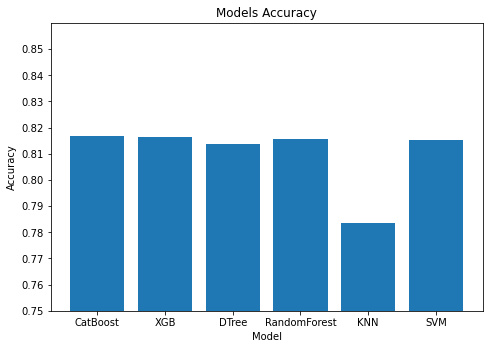

In [12]:
# Plot models vs accuracy(ndcg)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_yticks(np.arange(0.75, 0.86, 0.01))
ax.set_ylim([0.75, 0.86])
plt.title('Models Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
x = ['CatBoost', 'XGB', 'DTree', 'RandomForest', 'KNN', 'SVM']
y = [acc_ndcg(y_test, y_pred_proba_cb), acc_ndcg(y_test, y_pred_proba_xgb) , acc_ndcg(y_test, y_pred_proba_dtree), acc_ndcg(y_test, y_pred_proba_rndforest), acc_ndcg(y_test, y_pred_proba_knn), acc_ndcg(y_test, y_pred_proba_svm)]
ax.bar(x,y)
#plt.savefig('models_acc.png')
plt.show()

In [ ]:
# Predicting

y_pred_proba = clf_cb.predict_proba(test)
predictions = pd.DataFrame(columns=['id', 'country_destination'])
temp = pd.read_csv('test_users.csv')
temp = temp['id'].values
idx = []
cd = []
for i in temp:
    for _ in range(5):
        idx.append(i)
idx = np.array(idx)
predictions['id'] = idx

for i in range(len(y_pred_proba)):
    pred = le.inverse_transform(np.argsort(y_pred_proba[i])[-5:][::-1])
    for p in pred:
        cd.append(p)
cd = np.array(cd)
predictions['country_destination'] = cd
predictions.to_csv('predictions.csv', index=False)

In [14]:
predictions.head()

,id,country_destination
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,IT
